# Training RNNs by BPTT

This notebook will take you through the process of constructing a Backpropagation Through Time (BPTT) graph and using it to optimize a simple recurrent neural network (RNN). In particular, we'll use it to train a network to predict the next frame of some videos from a simple synthetic video dataset. After training the network we'll sample it's predictions to demonstrate that it has learned a precise model of input videos.

There several dependencies that you will need to have installed for this notebook to work. Most notably:
- tensorflow
- pyyaml
- ffmpeg (or another suitable video backend for matplotlib)

The tensorflow and pyyaml can be obtained from pip. ffmpeg can be downloaded from https://www.ffmpeg.org/download.html. You will need to make sure ffmpeg binary is placed in a folder that is accessed by your $PATH environment variable.

In [1]:
%matplotlib inline
import tensorflow as tf
import yaml
import time
from datetime import datetime
import sys, os
import pprint
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as image
from IPython.display import HTML

In [2]:
import hippo.util as util
from hippo.util import Peace
from hippo.networks import Network
import hippo.data as data

Usually it's a good idea to fix a random seed to ensure reproducible behavior-- feel free to try a different seed-- you may get slightly different behavior particularly in how quickly the training error converges.

In [3]:
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

First we'll load a bunch parameters: parameters for generating the data set, parameters to specify the network itself, parameters used to optimize the network during training. These all get stored in a hparams hash. We'll pass this around through much of the rest of the code.

If you're curious about what one of them does after you've finished a first pass through the notebook, you're welcome to try changing its value and rerunning the rest of the notebook. I can't promise it won't break the rest of the code though!

In [4]:
hparams = util.load_params('bouncing_block_prediction.yaml')

print('-------------')
print('Running on the following params:')
pprint.pprint(hparams)
print('-------------')

-------------
Running on the following params:
{'data': {'block_size': [2, 2],
          'data_split': [0.8, 0.1, 0.1],
          'frame_dim': [10, 10],
          'n_frames': 100,
          'n_video': 1000,
          'type': 'video',
          'v_range': [1, 3]},
 'layers': [{'dim': 'input_dim'},
            {'dim': [256], 'type': 'SRNN'},
            {'dim': 'input_dim', 'type': 'Linear'}],
 'n_batch': 64,
 'n_prop': 10,
 'n_reject': 3,
 'n_samples': 100,
 'n_train_steps': 20001,
 'optimizer': {'algorithm': 'adam',
               'eta0': 0.01,
               'eta_decay_factor': 0.5,
               'steps_til_decay': 2000},
 'prediction_delay': 1,
 'run_name': 'bouncing_block_prediction',
 'use_params': ['defaults.yaml', 'single_layer_rnn.yaml']}
-------------


Now we'll generate a synthetic dataset-- videos of a small block bouncing with random velocity within the image frame. Of course it's always important to separate training data from validation and test data so we do that right from beginning.

In [5]:
train_data, valid_data, test_data = data.gen_datasets(hparams)

# Our parameter files leave the network input and output dimension unspecified since they often
# will depend on the data
hparams['layers'][0]['dim'] = hparams['data']['dim']
hparams['layers'][-1]['dim'] = hparams['data']['dim']

print ('The completed network structure parameters:')
pprint.pprint(hparams['layers'])

The completed network structure parameters:
[{'dim': [100]},
 {'dim': [256], 'type': 'SRNN'},
 {'dim': [100], 'type': 'Linear'}]


Let's check out what one the videos in our dataset looks like. Change the index into the training data below if you want to see a different video.

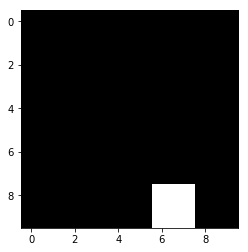

In [6]:
video = train_data[0]

fig = plt.figure()
axis_image = plt.imshow(video[0,:,:], cmap="Greys_r", interpolation="none", animated=True)

def init():
    axis_image.set_clim(vmin=0.0, vmax=1.0)
    return axis_image,

def update(i):
    axis_image.set_array(video[i,:,:])
    return axis_image,

ani = animation.FuncAnimation(fig, update, init_func=init, frames=range(video.shape[0]), interval=50, blit=True)


HTML(ani.to_html5_video())

Time to set up a network. The Network class takes the hyper parameters and allocates weights for each of the specified layers. It also provides the step function we'll use when building a BPTT training graph and functions for saving and reseting network state that are used to allow the network state to carry across truncation boundaries in during truncated BPTT.

In [7]:
def build_network(hparams):
    with tf.name_scope('network_parameters'):
        net = Network(hparams)

    return net

net = build_network(hparams)

Now let's create the function unfolds the recurrent computation in time, i.e. let's build the BPTT graph. This basically just requires iterating the step function of the network we've created, but we'll also need to create input variables, and compute a loss (the code currently uses the L2 distance).

The network's step function takes an input and produces a new hidden state of it's RNN layer from the old hidden state and the input. Then it computes a linear function of the hidden state to produce an output at each timestep. The actual math of this is hidden away in hippo/networks.py nad hippo/layers.py. Feel to check them out if you are interested.

In [8]:
def build_forward_prop_graph(net, n_batch, n_prop, n_reject, summarize, hparams):
    # The network input and teacher signal nodes
    # They reference the same placeholders because we are doing input prediction
    # TODO: update this to the more general context
    # The forward propagation graph
    xs, ys, ys_valid, ys_hat, losses = [], [], [], [], []


    with tf.name_scope('t_0'):
        train_state_store = net.get_new_state_store(n_batch)
        train_state = net.state_from_store(train_state_store)

    last_state = []

    for i in range(n_prop):
        with tf.name_scope('t_' + str(i+1)):
            x_batch = tf.placeholder(tf.float32, shape=[n_batch, *net.input_dim], name = 'x')
            y_batch = tf.placeholder(tf.float32, shape=[n_batch, *net.input_dim], name = 'y')
            y_valid_batch = tf.placeholder(tf.bool, shape=[n_batch], name = 'y_valid')

            xs.append(x_batch)
            ys.append(y_batch)
            ys_valid.append(y_valid_batch)


            train_state, [y_hat_batch] = net.step(train_state, x_batch)
            ys_hat.append(y_hat_batch)

            if i == n_prop - n_reject - 1:
                last_state = train_state

            # We want to ignore first n_bptt_reject outputs on this since
            # their gradient calculations will significantly more biased the
            # later outputs
            if i >= n_reject:
                loss = data.loss(hparams, y_hat_batch, y_batch, y_valid_batch)
                losses.append(loss)

    # This update that allows state to carry across f-props so our network
    # state can carry info across arbitrarily long input histories
    with tf.name_scope('save_and_reset'):
        store_state_op = net.store_state_op(last_state, train_state_store)
        reset_state_op = net.reset_state_op(train_state_store)


    # Our training objective function
    with tf.name_scope('loss_statistics'):
        all_losses = tf.stack(losses, name='all_losses')
        mean_loss = tf.reduce_mean(all_losses, name='mean_loss')

    Graph_Components = namedtuple('BPTT_Graph',
        'xs ys ys_valid ys_hat err_func state_store_op reset_state_op')
    graph_components = Graph_Components(xs=xs, ys = ys, ys_valid = ys_valid,
        ys_hat = ys_hat, err_func=mean_loss, state_store_op=store_state_op,
        reset_state_op=reset_state_op)

    return graph_components

We use this function to build our BPTT training graph. We'll also use it to build a single timestep version of the graph which is useful for things like sampling the network's predictions.

In [9]:
def build_train_graph(net, hparams):
    n_batch = hparams['n_batch']
    n_prop = hparams['n_prop']
    n_reject = hparams['n_reject']

    with tf.name_scope('BPTT_Graph'):
        return build_forward_prop_graph(net, n_batch, n_prop, n_reject, True, hparams)

def build_sampling_graph(net, hparams):
    n_batch = 1
    n_prop = 1
    n_reject = 0

    with tf.name_scope('Sampler_Graph'):
        return build_forward_prop_graph(net, n_batch, n_prop, n_reject, False, hparams)
    
train_components = build_train_graph(net, hparams)
sampler_components = build_sampling_graph(net, hparams)

The last piece of our graph is optimizer. This is what we use to compute gradients of the loss function and update the weights accordingly.

In [10]:
def build_optimizer(err_func, hparams):
    opt_params = hparams['optimizer']

    with tf.name_scope('optimizer'):
        t = tf.Variable(0, name= 't', trainable=False) # the step variable

        steps_til_decay = opt_params.get('steps_til_decay', 2000)
        decay_factor = opt_params.get('eta_decay_factor', .5)
        staircase = opt_params.get('staircase', True)
        grad_clip_norm = opt_params.get('grad_clip_norm', 1.0)

        if opt_params['algorithm'] == 'adam':
            eta = tf.train.exponential_decay(opt_params['eta0'], t, steps_til_decay,
                decay_factor, staircase=staircase)
            optimizer = tf.train.AdamOptimizer(learning_rate=eta)
        elif opt_params['algorithm'] == 'sgd':
            eta = tf.train.exponential_decay(opt_params['eta0'], t, steps_til_decay,
                decay_factor, staircase=staircase)
            optimizer = tf.train.GradientDescentOptimizer(eta)
        else:
            raise Exception('I dunno nothing about that optimizer')

        grads, params = zip(*optimizer.compute_gradients(err_func))
        clipped_grads, _ = tf.clip_by_global_norm(grads, grad_clip_norm)
        optimize_op = optimizer.apply_gradients(zip(clipped_grads, params), global_step=t)


    Optimizer = namedtuple('Optimizer', 'optimize_op t eta')
    return Optimizer(optimize_op=optimize_op, t=t, eta=eta)

optimizer = build_optimizer(train_components.err_func, hparams)

Now that the graph is all together let's use tensorboard to take a look at it. The utility function used to do this in a notebook comes from the code snippet at: https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter

In [11]:
util.show_graph(tf.get_default_graph().as_graph_def())

Now that the graph is built we can use it to train our network. To do this we'll need to feed our BPTT graph with sequences of inputs and sequences of outputs. Since we are predicting the next frame of the video the outputs are just the inputs shifted forward by one timestep. First we create some classes to provide these sequences.

In [12]:
input_producer, output_producer = data.gen_prediction_data_producers(train_data, hparams)

Next we need to initialize network weights. To this we need to create as tensorflow session which will launch the graph on our compute hardware (CPU or GPU).

In [13]:
session = tf.InteractiveSession()

init_op = tf.global_variables_initializer()
session.run(init_op)

The real work commences. We'll feed in the data and compute the forward propagation graph. In turn the optimizer, will run backpropagate the loss gradients and use them to update the network weights. First we'll just do 1000 iterations of this.

Average error at step 100 : 1.36404073656 learning rate: 0.01
Average error at step 200 : 1.22679183781 learning rate: 0.01
Average error at step 300 : 1.20046659291 learning rate: 0.01
Average error at step 400 : 1.2242337507 learning rate: 0.01
Average error at step 500 : 1.18371523559 learning rate: 0.01
Average error at step 600 : 1.15856240869 learning rate: 0.01
Average error at step 700 : 1.07131199718 learning rate: 0.01
Average error at step 800 : 0.986523236632 learning rate: 0.01
Average error at step 900 : 0.854566757381 learning rate: 0.01
Average error at step 1000 : 0.660651335418 learning rate: 0.01


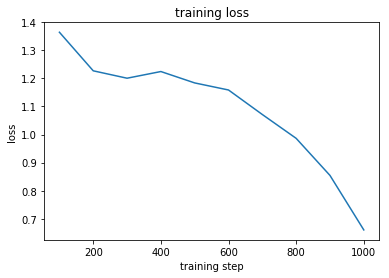

In [14]:
def run_training(session, train_components, optimizer, input_producer, 
    output_producer, n_train_steps, hparams):
    '''
    Run train the network in graph by optimizing it on the training inputs
        @param graph: the tensorflow graph with bptt graph and optimizer
        @param train_components: components of the bptt_graph (input, err, save, reset...)
        @param optimizer: components of the optimizer graph (optimize_op, eta...)
        @param input_producer: an object to supply input batches
        @param output_producer: an object to supply output batches
        @param save_state_op: op to save state across truncation boundaries
        @param reset_state_op: op to reset state to some initialization
        @param n_train_steps: the number of forward propagation to perform
        @param hparams: bet you couldn't have guessed it's the hyperparameters

        @return: the history the training error

    TODO: start using a simulator and replace the input_generator with a world model ;)
    '''

    n_prop = hparams['n_prop']

    train_error_hist = []
    summary_error = 0.0
    summary_freq = 100

    start_step = optimizer.t.eval()
    
    for step in range(n_train_steps):

        # assert 'train_state_reset_rate' in hparams
        # reset_rate = n_prop/hparams['train_state_reset_rate']
        # if np.random.poisson(reset_rate) > 0:
        #     print('State reset!')
        #     session.run([train_components.reset_state_op])

        # Set up input value -> input var mapping
        input_window, _  = input_producer.next_window()
        output_window, is_valid = output_producer.next_window()
        feed_dict = dict()
        for i in range(n_prop):
            feed_dict[train_components.xs[i]] = input_window[i]
            feed_dict[train_components.ys[i]] = output_window[i]
            feed_dict[train_components.ys_valid[i]] = is_valid[i]

        to_compute = [train_components.err_func, optimizer.eta,
            optimizer.optimize_op, train_components.state_store_op]
        error_val, eta_val, _, _ = session.run(to_compute, feed_dict=feed_dict)

        summary_error += error_val

        if (step + 1) % summary_freq == 0 and step > 0:
            mean_error = summary_error/summary_freq

            train_error_hist.append((step + start_step + 1, mean_error))

            print('Average error at step', step + start_step + 1, ':', mean_error, 'learning rate:', eta_val)
            summary_error = 0.0


    return util.nested_list_to_array(train_error_hist)

train_error_hist = run_training(session, train_components, optimizer, input_producer, output_producer, 1000, hparams)

plt.figure()
plt.plot(train_error_hist[:,0], train_error_hist[:, 1])
plt.title('training loss')
plt.xlabel('training step')
plt.ylabel('loss')
plt.show()

Now that we've trained the model a bit let's sample from to see what its predictions look like. When sampling from the model, we generally need to seed it with inputs to get its hidden state to point in the space that it is good at continuing from. In this case we'll use a few frames a video from the training data.

After we've seed the hidden state we start to feed the network's own predictions into it as the next input. Using this approach the samples from the model will stay close to original input only if its predictions are very accurate. 

In [15]:
def sample(session, sampler_components, seed, n_sample_steps, hparams):
    n_seed = seed.shape[0]

    input_producer = data.gen_one_step_producer(seed, hparams)
    samples = []

    y_hat = sampler_components.ys_hat[0]
    if hparams['data']['type'] == 'video':
        dist = y_hat # we currently just predict the mean so there's no good way of sampling
    elif hparams['data']['type'] == 'text':
        dist = tf.nn.softmax(y_hat)
    else:
        raise data.DataTypeException()

    to_compute = [dist, sampler_components.state_store_op]

    for step in range(n_seed):
        input_window, _ = input_producer.next_window()

        feed_dict = {sampler_components.xs[0]: input_window[0]}
        dist, _ = session.run(to_compute, feed_dict = feed_dict)

        prediction = data.sample_distribution(dist, hparams)


    for step in range(n_sample_steps):
        prediction = data.sample_distribution(dist, hparams)
        samples.append(np.reshape(prediction, hparams['data']['frame_dim']))

        if step == n_sample_steps - 1:
            break # We already have sampled n_sample_steps times

        feed_dict = {sampler_components.xs[0]: prediction}
        dist, _ = session.run(to_compute, feed_dict = feed_dict)

    return np.stack(samples)

n_seed_frames = 10
seed_idx = 0
n_frames = hparams['data']['n_frames']
n_samples = n_frames - n_seed_frames


sample_seed = train_data[seed_idx][:n_seed_frames,:,:]
samples = sample(session, sampler_components, sample_seed, n_samples, hparams)

Let's compare the generated sample to the remainder of the video used to generate it.

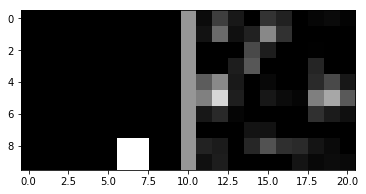

In [16]:
orig_video = train_data[seed_idx][n_seed_frames:,:,:]

h, w = hparams['data']['frame_dim']
compare_video = np.zeros((n_samples, h, 2*w + 1))
compare_video[:,:,:w] = orig_video
compare_video[:,:,w] = .5
compare_video[:,:,w+1:] = samples

fig = plt.figure()
axis_image = plt.imshow(compare_video[0,:,:], cmap="Greys_r", interpolation="none", animated=True)

def init():
    axis_image.set_clim(vmin=0.0, vmax=1.0)
    return axis_image,

def update(i):
    axis_image.set_array(compare_video[i,:,:])
    return axis_image,

ani = animation.FuncAnimation(fig, update, init_func=init, frames=range(compare_video.shape[0]), interval=50, blit=True)


HTML(ani.to_html5_video())

Obviously, it's not doing all that well yet. But don't despair we just need to do some more training. Try training for another 2000 steps and then sample from the net again.

I'll leave this part to you. 

Note that the learning rate will automatically decrease by half after finish step 2000- this is because we set an annealing schedule for the learning rate when specified the optimizer.

Average error at step 1100 : 0.550372106731 learning rate: 0.01
Average error at step 1200 : 0.442529313564 learning rate: 0.01
Average error at step 1300 : 0.358174827844 learning rate: 0.01
Average error at step 1400 : 0.307948536426 learning rate: 0.01
Average error at step 1500 : 0.256463870108 learning rate: 0.01
Average error at step 1600 : 0.230932076499 learning rate: 0.01
Average error at step 1700 : 0.181241738349 learning rate: 0.01
Average error at step 1800 : 0.175305581465 learning rate: 0.01
Average error at step 1900 : 0.156900689602 learning rate: 0.01
Average error at step 2000 : 0.144413858913 learning rate: 0.01
Average error at step 2100 : 0.0717308647558 learning rate: 0.005
Average error at step 2200 : 0.0569695213251 learning rate: 0.005
Average error at step 2300 : 0.0522055732645 learning rate: 0.005
Average error at step 2400 : 0.047329125274 learning rate: 0.005
Average error at step 2500 : 0.0480048057809 learning rate: 0.005
Average error at step 2600 : 0.

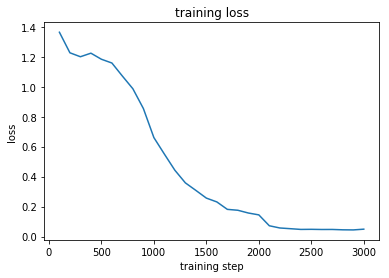

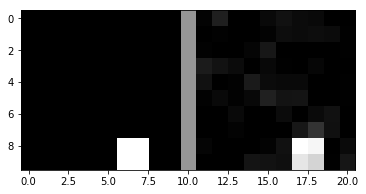

In [17]:
new_hist = run_training(session, train_components, optimizer, input_producer, output_producer, 2000, hparams)
train_error_hist = np.concatenate((train_error_hist, new_hist))

plt.figure()
plt.plot(train_error_hist[:,0], train_error_hist[:, 1])
plt.title('training loss')
plt.xlabel('training step')
plt.ylabel('loss')
plt.show()

samples = sample(session, sampler_components, sample_seed, n_samples, hparams)

orig_video = train_data[seed_idx][n_seed_frames:,:,:]

h, w = hparams['data']['frame_dim']
compare_video = np.zeros((n_samples, h, 2*w + 1))
compare_video[:,:,:w] = orig_video
compare_video[:,:,w] = .5
compare_video[:,:,w+1:] = samples

fig = plt.figure()
axis_image = plt.imshow(compare_video[0,:,:], cmap="Greys_r", interpolation="none", animated=True)

def init():
    axis_image.set_clim(vmin=0.0, vmax=1.0)
    return axis_image,

def update(i):
    axis_image.set_array(compare_video[i,:,:])
    return axis_image,

ani = animation.FuncAnimation(fig, update, init_func=init, frames=range(compare_video.shape[0]), interval=50, blit=True)


HTML(ani.to_html5_video())

You'll probably see that the samples have improved significantly but that they still start to degrade as the video goes on (it's also possible that samples will still be pretty shitty-- just keep training if that's the case). You're welcome to continue training if you like-- the samples will keep getting better as the training error goes down. 

Because all of the training has been done with clean frames from the synthetic video dataset, the network doesn't know what to do when encounters it's own sampling noise and can tend to amplify the noise as sampling continues. You might implement a strategy for training the network to be more robust to its own sampling noise.

Alternatively, do you remember that train/validate/test split we made at the beginning of notebook? Every true devotee of the church of machine learning knows that it's most foul vanity to assume your model is doing well just because it has a good training error. We must be ever vigilant against the sin of overfitting. You better go back and see how your model does the test set and use the validation error to pick the best point to stop training, you heathen!

Or you could change the network specification in hparams to add another layer (or 40) to network, because it's not deep until you've got at least 41 layers.

Last, but not least, don't forget to give a good sign off!

In [18]:
p = Peace()
p.out()

Peace out!
